In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import *
from keras.models import Sequential, Model, load_model
from tensorflow.keras import mixed_precision
import keras.backend as K
import pandas as pd
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import splitfolders
import zipfile
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, LearningRateScheduler
import shutil
import sys
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import locale
locale.setlocale(locale.LC_ALL, 'bn_BD.UTF-8')
from keras.preprocessing.image import ImageDataGenerator


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import pandas as pd
df = pd.read_csv('train.csv')

In [ ]:
df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [ ]:
grapheme_roots = df['grapheme_root'].values
n, c = np.unique(grapheme_roots, return_counts=True)
total_grapheme_roots = len(n)
print(total_grapheme_roots, 'total_grapheme_roots')


vowel_diacritic = df['vowel_diacritic'].values
n, c = np.unique(vowel_diacritic, return_counts=True)
total_vowel_diacritic = len(n)
print(total_vowel_diacritic, 'total_vowel_diacritic')


consonant_diacritic = df['consonant_diacritic'].values
n, c = np.unique(consonant_diacritic, return_counts=True)
total_consonant_diacritic = len(n)
print(total_consonant_diacritic, 'total_consonant_diacritic')


168 total_grapheme_roots
11 total_vowel_diacritic
7 total_consonant_diacritic


In [ ]:
df

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [ ]:
X = df['image_id']
X

0              Train_0
1              Train_1
2              Train_2
3              Train_3
4              Train_4
              ...     
200835    Train_200835
200836    Train_200836
200837    Train_200837
200838    Train_200838
200839    Train_200839
Name: image_id, Length: 200840, dtype: object

In [ ]:
y = df.drop(['image_id'], axis=1)
y

,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,15,9,5,ক্ট্রো
1,159,0,0,হ
2,22,3,5,খ্রী
3,53,2,2,র্টি
4,71,9,5,থ্রো
...,...,...,...,...
200835,22,7,2,র্খে
200836,65,9,0,ত্তো
200837,2,1,4,অ্যা
200838,152,9,0,স্নো


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
def augment_image(img):
    data_augmentation = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=False,
        vertical_flip=False
    )
    img = data_augmentation.random_transform(img)
    return img

In [ ]:
batch_size = 256

def loader(img_list, img_labels,augment=True):
    L = len(img_list)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            z = np.zeros((len(img_list[batch_start:limit]), 120, 120, 1))
            for i, f in enumerate(img_list[batch_start:limit]):
                img = tf.keras.utils.load_img('./images/'+f+'.jpg', color_mode='grayscale',target_size=(120, 120))
                img = tf.keras.utils.img_to_array(img)/255.
                if augment:
                    img = augment_image(img)
                z[i, :, :, :] = img
            X = z
            labels = img_labels[batch_start:limit]

            Y = []

            grapheme_roots = []
            vowel_diacritics = []
            consonant_diacritics = []
            for label in labels:
                grapheme_roots.append(label[0])
                vowel_diacritics.append(label[1])
                consonant_diacritics.append(label[2])

            grapheme_roots = np.array(grapheme_roots)
            vowel_diacritics = np.array(vowel_diacritics)
            consonant_diacritics = np.array(consonant_diacritics)

            yield (X,{'grapheme_root': grapheme_roots, 'vowel_diacritic': vowel_diacritics, 'consonant_diacritic': consonant_diacritics})
            batch_start += batch_size
            batch_end += batch_size

In [ ]:
train_generator = loader(X_train.values, y_train.values)
val_generator = loader(X_val.values, y_val.values)

In [ ]:
def simple_model():

    f = 16
    x = Input(shape=(120,120,1,))
    init=x

    conv = Conv2D(f, 3, strides=1, padding='same', activation='relu')(init)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*2, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*4, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    conv = Conv2D(f*8, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)


    conv = Conv2D(f*16, 3, strides=1, padding='same', activation='relu')(conv)
    conv = MaxPooling2D(2)(conv)

    f = Flatten()(conv)

    d_grapheme_root = Dense(512, activation='relu')(f)
    d_grapheme_root = Dropout(0.5)(d_grapheme_root)
    d_grapheme_root = Dense(256, activation='relu')(d_grapheme_root)

    d_vowel_diacritic = Dense(512, activation='relu')(f)
    d_vowel_diacritic = Dropout(0.5)(d_vowel_diacritic)
    d_vowel_diacritic = Dense(256, activation='relu')(d_vowel_diacritic)

    d_consonant_diacritic = Dense(512, activation='relu')(f)
    d_consonant_diacritic = Dropout(0.5)(d_consonant_diacritic)
    d_consonant_diacritic = Dense(256, activation='relu')(d_consonant_diacritic)


    grapheme_root = Dense(total_grapheme_roots, activation='softmax', name='grapheme_root')(d_grapheme_root)
    vowel_diacritic = Dense(total_vowel_diacritic, activation='softmax', name='vowel_diacritic')(d_vowel_diacritic)
    consonant_diacritic = Dense(total_consonant_diacritic, activation='softmax', name='consonant_diacritic')(d_consonant_diacritic)


    model = Model(inputs=x, outputs=[grapheme_root, vowel_diacritic, consonant_diacritic])

    return model

model = simple_model()
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 120, 120, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_55 (Conv2D)             (None, 120, 120, 16  160         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_55 (MaxPooling2D  (None, 60, 60, 16)  0           ['conv2d_55[0][0]']              
 )                                                                                         

In [ ]:
media_start = './'
optimizer = Adam(0.001)

model_path = media_start+"test.hdf5"

checkpoint = ModelCheckpoint(model_path, save_freq="epoch",save_best_only=True,
    save_weights_only=False, monitor='val_loss', verbose=1)

csv_logger = CSVLogger(media_start+"log.csv")

ce = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
)

model.compile(optimizer = optimizer, loss=ce, metrics = ['accuracy'])

train_steps = len(X_train)//batch_size
val_steps = len(X_val)//batch_size

def scheduler(epoch):
    initial = 0.001
    lr = initial
    if epoch >= 10:
        lr = 0.0001
    return lr


scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

history = model.fit(train_generator,
        steps_per_epoch=train_steps,
        epochs=10,
        verbose=1,
        validation_data=val_generator,
        validation_steps=val_steps,
        callbacks=[checkpoint, csv_logger, scheduler_callback]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
564/564 [==============================] - ETA: 0s - loss: 6.4462 - grapheme_root_loss: 4.3165 - vowel_diacritic_loss: 1.2426 - consonant_diacritic_loss: 0.8871 - grapheme_root_accuracy: 0.0655 - vowel_diacritic_accuracy: 0.5480 - consonant_diacritic_accuracy: 0.7011
Epoch 1: val_loss improved from inf to 4.08227, saving model to .\test.hdf5
564/564 [==============================] - 590s 1s/step - loss: 6.4462 - grapheme_root_loss: 4.3165 - vowel_diacritic_loss: 1.2426 - consonant_diacritic_loss: 0.8871 - grapheme_root_accuracy: 0.0655 - vowel_diacritic_accuracy: 0.5480 - consonant_diacritic_accuracy: 0.7011 - val_loss: 4.0823 - val_grapheme_root_loss: 3.1648 - val_vowel_diacritic_loss: 0.4612 - val_consonant_diacritic_loss: 0.4562 - val_grapheme_root_accuracy: 0.2119 - val_vowel_diacritic_accuracy: 0.8405 - val_consonant_diacritic_accuracy: 0.8367 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning r

In [ ]:
# FOR RECONSTRUCTION PURPOSE
df_gr = pd.read_csv('train.csv')
df_gr = df_gr.drop_duplicates(subset=['grapheme'])
dv = df_gr.values
grapheme_roots = []
_grapheme_roots = []

for v in dv:
    if v[1] != 0 and v[2] == 0 and v[3] == 0 and v[-1] not in _grapheme_roots:
        _grapheme_roots.append(v[-1])
        grapheme_roots.append({'numeric': v[1], 'value': v[-1]})

vowel_diacritics = {}
vowel_diacritics[0] = ''
vowel_diacritics[1] = 'া'
vowel_diacritics[2] = 'ি'
vowel_diacritics[3] = 'ী'
vowel_diacritics[4] = 'ু'
vowel_diacritics[5] = 'ূ'
vowel_diacritics[6] = 'ৃ'
vowel_diacritics[7] = 'ে'
vowel_diacritics[8] = 'ৈ'
vowel_diacritics[9] = 'ো'
vowel_diacritics[10] = 'ৌ'


consonant_diacritics = {}
consonant_diacritics[0] = ''
consonant_diacritics[1] = 'ঁ'
consonant_diacritics[2] = '\u09b0\u09cd'
consonant_diacritics[3] = 'র্য' #//ref + ja fala
consonant_diacritics[4] = '্য'
consonant_diacritics[5] = '্র'
consonant_diacritics[6] = '্র্য'
consonant_diacritics[7] = 'র্্র'#ref + ra fala


def get_grapheme_root(numeric):
    for item in grapheme_roots:
        if item['numeric'] == numeric:
            return item['value']
    return ''

def get_vowel_diacritic(numeric):
    global vowel_diacritics
    return vowel_diacritics[numeric]

def get_consonant_diacritic(numeric):
    global consonant_diacritics
    return consonant_diacritics[numeric]



In [ ]:
consonant_middle=[5,4,6]
consonant_after=[1]
consonant_before=[2]


In [ ]:
def get_grapheme(gr,vd,cd):
    consonant_middle=[5,4,6]
    consonant_after=[1]


    if cd in consonant_middle
        return get_grapheme_root(gr)+get_consonant_diacritic(cd)+get_vowel_diacritic(vd)
    elif cd==2 #ref
        return get_consonant_diacritic(cd)+get_grapheme_root(gr)+get_vowel_diacritic(vd)
    elif cd==3 #ref+ ja fala
        return '\u09b0\u09cd'+get_grapheme_root(gr)+'্য'+get_vowel_diacritic(vd)
    elif cd==7 #ref+ ra fala
        return '\u09b0\u09cd'+get_grapheme_root(gr)+'্র'+get_vowel_diacritic(vd)
    elif cd in consonant_after
        return get_grapheme_root(gr)+get_vowel_diacritic(vd)+get_consonant_diacritic(cd)

In [ ]:


print(get_grapheme(23,0,7))
print(get_grapheme(23,1,7))
print(get_grapheme(23,2,7))
print(get_grapheme(23,3,7))
print(get_grapheme(23,4,7))
print(get_grapheme(23,5,7))
print(get_grapheme(23,6,7))
print(get_grapheme(23,7,7))
print(get_grapheme(23,8,7))
print(get_grapheme(23,9,7))
print(get_grapheme(23,10,7))







গর্্র
গার্্র
গির্্র
গীর্্র
গুর্্র
গূর্্র
গৃর্্র
গের্্র
গৈর্্র
গোর্্র
গৌর্্র


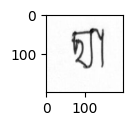

grapheme_root ছ + constant_diacritic ্য + vowel_diacritic া =  ছা্য
grapheme_root ছ + vowel_diacritic া + consonant_diacritic ্য =  ছ্যা
Grapheme from CSV (Prediction) =  ছ্যা
Actual Grapheme (True) =  ছ্যা


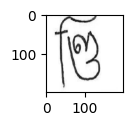

grapheme_root ন্থ + constant_diacritic  + vowel_diacritic ি =  ন্থি
grapheme_root ন্থ + vowel_diacritic ি + consonant_diacritic  =  ন্থি
Grapheme from CSV (Prediction) =  ন্থি
Actual Grapheme (True) =  ণ্ডি


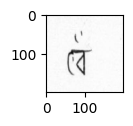

grapheme_root ব + constant_diacritic ঁ + vowel_diacritic ে =  বেঁ
grapheme_root ব + vowel_diacritic ে + consonant_diacritic ঁ =  বঁে
Grapheme from CSV (Prediction) =  বেঁ
Actual Grapheme (True) =  বেঁ


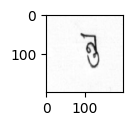

grapheme_root ন্ত + constant_diacritic  + vowel_diacritic  =  ন্ত
grapheme_root ন্ত + vowel_diacritic  + consonant_diacritic  =  ন্ত
Grapheme from CSV (Prediction) =  ন্ত
Actual Grapheme (True) =  ন্ত


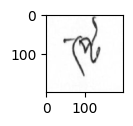

grapheme_root প্ট + constant_diacritic  + vowel_diacritic ে =  প্টে
grapheme_root প্ট + vowel_diacritic ে + consonant_diacritic  =  প্টে
Grapheme from CSV (Prediction) =  প্টে
Actual Grapheme (True) =  প্টে


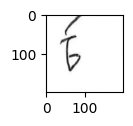

grapheme_root চ + constant_diacritic র্ + vowel_diacritic  =  চর্
grapheme_root চ + vowel_diacritic  + consonant_diacritic র্ =  চর্
Grapheme from CSV (Prediction) =  র্চ
Actual Grapheme (True) =  র্চ


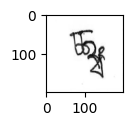

grapheme_root চ্ছ্ব + constant_diacritic  + vowel_diacritic  =  চ্ছ্ব
grapheme_root চ্ছ্ব + vowel_diacritic  + consonant_diacritic  =  চ্ছ্ব
Grapheme from CSV (Prediction) =  চ্ছ্ব
Actual Grapheme (True) =  চ্ছ্ব


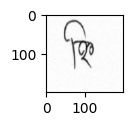

grapheme_root হ্ন + constant_diacritic  + vowel_diacritic ি =  হ্নি
grapheme_root হ্ন + vowel_diacritic ি + consonant_diacritic  =  হ্নি
Grapheme from CSV (Prediction) =  হ্নি
Actual Grapheme (True) =  হ্নি


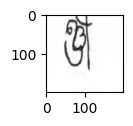

grapheme_root স্ত + constant_diacritic  + vowel_diacritic ী =  স্তী
grapheme_root স্ত + vowel_diacritic ী + consonant_diacritic  =  স্তী
Grapheme from CSV (Prediction) =  স্তী
Actual Grapheme (True) =  ঞ্জী


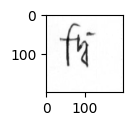

grapheme_root দ্ব + constant_diacritic  + vowel_diacritic ি =  দ্বি
grapheme_root দ্ব + vowel_diacritic ি + consonant_diacritic  =  দ্বি
Grapheme from CSV (Prediction) =  দ্বি
Actual Grapheme (True) =  দ্বি


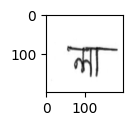

grapheme_root ন + constant_diacritic  + vowel_diacritic া =  না
grapheme_root ন + vowel_diacritic া + consonant_diacritic  =  না
Grapheme from CSV (Prediction) =  না
Actual Grapheme (True) =  ন্মা


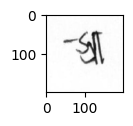

grapheme_root স + constant_diacritic ্র + vowel_diacritic া =  সা্র
grapheme_root স + vowel_diacritic া + consonant_diacritic ্র =  স্রা
Grapheme from CSV (Prediction) =  স্রা
Actual Grapheme (True) =  স্রা


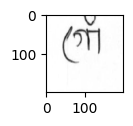

grapheme_root গ + constant_diacritic ঁ + vowel_diacritic ো =  গোঁ
grapheme_root গ + vowel_diacritic ো + consonant_diacritic ঁ =  গঁো
Grapheme from CSV (Prediction) =  গোঁ
Actual Grapheme (True) =  গোঁ


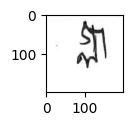

grapheme_root গ্ন + constant_diacritic  + vowel_diacritic া =  গ্না
grapheme_root গ্ন + vowel_diacritic া + consonant_diacritic  =  গ্না
Grapheme from CSV (Prediction) =  গ্না
Actual Grapheme (True) =  গ্লা


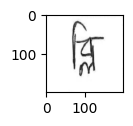

grapheme_root ব্ল + constant_diacritic  + vowel_diacritic ি =  ব্লি
grapheme_root ব্ল + vowel_diacritic ি + consonant_diacritic  =  ব্লি
Grapheme from CSV (Prediction) =  ব্লি
Actual Grapheme (True) =  ব্লি


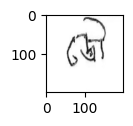

grapheme_root দ + constant_diacritic ্র + vowel_diacritic ৌ =  দৌ্র
grapheme_root দ + vowel_diacritic ৌ + consonant_diacritic ্র =  দ্রৌ
Grapheme from CSV (Prediction) =  দ্রৌ
Actual Grapheme (True) =  দ্রৌ


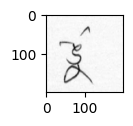

grapheme_root ভ + constant_diacritic র্ + vowel_diacritic ু =  ভুর্
grapheme_root ভ + vowel_diacritic ু + consonant_diacritic র্ =  ভর্ু
Grapheme from CSV (Prediction) =  র্ভু
Actual Grapheme (True) =  র্ভু


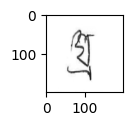

grapheme_root ঘ + constant_diacritic ্র + vowel_diacritic  =  ঘ্র
grapheme_root ঘ + vowel_diacritic  + consonant_diacritic ্র =  ঘ্র
Grapheme from CSV (Prediction) =  ঘ্র
Actual Grapheme (True) =  ঘ্র


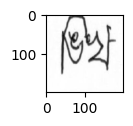

grapheme_root ঙ্খ + constant_diacritic  + vowel_diacritic ি =  ঙ্খি
grapheme_root ঙ্খ + vowel_diacritic ি + consonant_diacritic  =  ঙ্খি
Grapheme from CSV (Prediction) =  ঙ্খি
Actual Grapheme (True) =  ঙ্খি


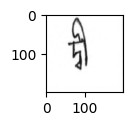

grapheme_root দ্ব + constant_diacritic  + vowel_diacritic ী =  দ্বী
grapheme_root দ্ব + vowel_diacritic ী + consonant_diacritic  =  দ্বী
Grapheme from CSV (Prediction) =  দ্বী
Actual Grapheme (True) =  দ্বী


In [ ]:
model.load_weights('test.hdf5')

y_true_grapheme_root = []
y_true_vowel_diacritic = []
y_true_consonant_diacritic = []

y_pred_grapheme_root = []
y_pred_vowel_diacritic = []
y_pred_consonant_diacritic = []

for i, f in enumerate(X_test):
    img = tf.keras.utils.load_img('./images/'+f+'.jpg', color_mode='grayscale',target_size=(120, 120))
    img = tf.keras.utils.img_to_array(img)/255.
    img = np.expand_dims(img, axis=0)
    pr = model.predict(img, verbose=0)

    pred_grapheme_root = np.argmax(pr[0], axis=-1)[0]
    pred_vowel_diacritic = np.argmax(pr[1], axis=-1)[0]
    pred_consonant_diacritic = np.argmax(pr[2], axis=-1)[0]


    true_grapheme_root = y_test['grapheme_root'].iloc[i]
    true_vowel_diacritic = y_test['vowel_diacritic'].iloc[i]
    true_consonant_diacritic = y_test['consonant_diacritic'].iloc[i]


    y_pred_grapheme_root.append(pred_grapheme_root)
    y_pred_vowel_diacritic.append(pred_vowel_diacritic)
    y_pred_consonant_diacritic.append(np.argmax(pr[2], axis=-1)[0])

    y_true_grapheme_root.append(y_test['grapheme_root'].iloc[i])
    y_true_vowel_diacritic.append(y_test['vowel_diacritic'].iloc[i])
    y_true_consonant_diacritic.append(y_test['consonant_diacritic'].iloc[i])


    if i < 20:

        plt.rcParams["figure.figsize"] = (1,1)

        plt.imshow(img[0, :, :, :], cmap='gray')
        plt.show()

        pred_grapheme_root_char = get_grapheme_root(pred_grapheme_root)
        pred_vowel_diacritic_char = get_vowel_diacritic(pred_vowel_diacritic)
        pred_consonant_diacritic_char = get_consonant_diacritic(pred_consonant_diacritic)


        grapheme_pred = pred_grapheme_root_char + pred_vowel_diacritic_char + pred_consonant_diacritic_char

        print('grapheme_root '+str(pred_grapheme_root_char)+' + constant_diacritic '+str(pred_consonant_diacritic_char)+' + vowel_diacritic '+str(pred_vowel_diacritic_char)+' = ', grapheme_pred)

        grapheme_pred = pred_grapheme_root_char + pred_consonant_diacritic_char + pred_vowel_diacritic_char

        print('grapheme_root '+str(pred_grapheme_root_char)+' + vowel_diacritic '+str(pred_vowel_diacritic_char)+' + consonant_diacritic '+str(pred_consonant_diacritic_char)+' = ', grapheme_pred)


        grapheme_from_csv = df_gr.loc[(df['grapheme_root'] == pred_grapheme_root) & (df['vowel_diacritic'] == pred_vowel_diacritic) & (df['consonant_diacritic'] == pred_consonant_diacritic)].values[0][-1]

        print("Grapheme from CSV (Prediction) = ", grapheme_from_csv)

        print("Actual Grapheme (True) = ", y_test['grapheme'].iloc[i])

In [ ]:
print("Accuracy score grapheme_root", accuracy_score(y_true_grapheme_root, y_pred_grapheme_root))

Accuracy score grapheme_root 0.8554072893845848


In [ ]:
print("Accuracy score vowel_diacritic", accuracy_score(y_true_vowel_diacritic, y_pred_vowel_diacritic))

Accuracy score vowel_diacritic 0.958424616610237


In [ ]:
print("Accuracy score consonant_diacritic", accuracy_score(y_true_consonant_diacritic, y_pred_consonant_diacritic))

Accuracy score consonant_diacritic 0.9575781716789484


In [ ]:
history.history

{'loss': [5.543370723724365, 2.490988254547119],
 'grapheme_root_loss': [3.859602928161621, 1.8519395589828491],
 'vowel_diacritic_loss': [0.95960533618927, 0.3287510573863983],
 'consonant_diacritic_loss': [0.7241612076759338, 0.3102959096431732],
 'grapheme_root_accuracy': [0.12212826311588287, 0.47813478112220764],
 'vowel_diacritic_accuracy': [0.6574194431304932, 0.8899402022361755],
 'consonant_diacritic_accuracy': [0.7545740008354187, 0.8940585255622864],
 'val_loss': [2.9628255367279053, 1.7065246105194092],
 'val_grapheme_root_loss': [2.2410244941711426, 1.2078303098678589],
 'val_vowel_diacritic_loss': [0.37639403343200684, 0.2501303553581238],
 'val_consonant_diacritic_loss': [0.3454073965549469, 0.24856464564800262],
 'val_grapheme_root_accuracy': [0.38502880930900574, 0.6509585380554199],
 'val_vowel_diacritic_accuracy': [0.8717309236526489, 0.9194924831390381],
 'val_consonant_diacritic_accuracy': [0.879044771194458, 0.9150598645210266],
 'lr': [0.001, 0.001]}